# Adding MONAI to PyTorch cifar10 classification

This notebook will show the flexibility of MONAI by taking a very simple PyTorch example and enhancing it with MONAI. The example we will begin with is classification on CIFAR10 dataset (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). This notebook is broken into following parts:

1. The original CIFAR-10 classification tutorial.
2. Using MONAI transforms without having to change any code.
3. Easily replacing a NueralNetwork with one provided in MONAI.

## Setup

CIFAR-10 is a classification dataset with 10 classes ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. Each image in CIFAR-10 is 3x32x32.

In [1]:
import sys
sys.path.append("../") 

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import monai
from PIL import Image
import numpy as np

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
%load_ext autoreload
%autoreload 2

Let's setup the dataloader and transform.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def get_train_test_cifar10(transform, batch_size=4):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

trainloader, testloader = get_train_test_cifar10(transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's show some images.

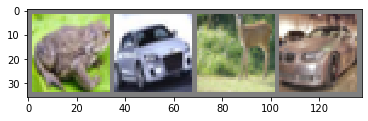

 frog   car  deer   car


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define a Convolution Neural Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Let's setup an optimizer

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Let's setup a simple training loop

In [9]:
from time import time

no_epochs = 2

def train(no_epochs, trainloader, optimizer, net, criterion, iteration_to_print=2000):
    no_iterations = len(trainloader)

    start = time()
    for epoch in range(no_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % iteration_to_print == iteration_to_print-1:    # print every 2000 mini-batches
                print(f'Epoch {epoch+1}/{no_epochs}, Iteration {i+1}/{no_iterations}: Loss = {running_loss / iteration_to_print}')
                running_loss = 0.0

    print(f'Finished Training in {time()-start} seconds.')
    
train(no_epochs, trainloader, optimizer, net, criterion)

Epoch 1/2, Iteration 2000/12500: Loss = 2.15399710214138
Epoch 1/2, Iteration 4000/12500: Loss = 1.8229549033045769
Epoch 1/2, Iteration 6000/12500: Loss = 1.6779237722754479
Epoch 1/2, Iteration 8000/12500: Loss = 1.5922331163287162
Epoch 1/2, Iteration 10000/12500: Loss = 1.519667302712798
Epoch 1/2, Iteration 12000/12500: Loss = 1.468738080114126
Epoch 2/2, Iteration 2000/12500: Loss = 1.406405058503151
Epoch 2/2, Iteration 4000/12500: Loss = 1.3510377175360917
Epoch 2/2, Iteration 6000/12500: Loss = 1.3371720226705075
Epoch 2/2, Iteration 8000/12500: Loss = 1.3430052463412285
Epoch 2/2, Iteration 10000/12500: Loss = 1.3140863975584507
Epoch 2/2, Iteration 12000/12500: Loss = 1.3029117776453496
Finished Training in 125.63213729858398 seconds.


Let's see some test images, run the network on them and see results

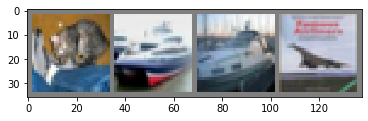

GroundTruth:    cat  ship  ship plane
Predicted:   frog  ship  ship  ship


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Let's look at the accuracy over test set.

In [11]:
print(device)

cuda:0


In [12]:
def get_accuracy(testloader, net, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
get_accuracy(testloader, net, device)

Accuracy of the network on the 10000 test images: 53 %


## Use transforms from MONAI

Now we will see how easy it is to use parts from MONAI to augment your existing code. Let's begin with using some transforms from MONAI.

First, We will reset the network parameters so we can train it again.

In [13]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
net.apply(weight_reset)
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Next, we will write a simple transform called `PILToNumpy` to convert the input from CIFAR-10 dataset to numpy arrays because MONAI transforms work on numpy arrays. Then, we can simple add the `AsChannelFirst`, `RandFlip`, `RandRotate` and `IntensityNormalizer` transforms. 

In [14]:
class PILToNumpy(object):
    def __init__(self):
        pass
    
    def __call__(self, img):
        assert isinstance(img, Image.Image), "input must be a PIL image."

        return np.array(img).astype(np.float32)

transform = transforms.Compose(
                [PILToNumpy(),
                 monai.transforms.AsChannelFirst(),
                 monai.transforms.IntensityNormalizer(np.array((0)), 
                                                      np.array((255))),
                 monai.transforms.RandFlip(prob=0.5, spatial_axis=[1]),
                 monai.transforms.ToTensor(dtype=torch.FloatTensor),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader, testloader = get_train_test_cifar10(transform)

Files already downloaded and verified
Files already downloaded and verified


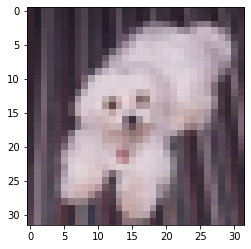

  dog  bird horse truck


In [15]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(images[0])
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
print(device)

cuda:0


In [17]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
print(type(images[0]))
print(images.to(device).type())

torch.Size([4, 3, 32, 32])
torch.Size([4])
<class 'torch.Tensor'>
torch.cuda.FloatTensor


Let's retrain the network and run it on test set.

In [18]:
train(no_epochs, trainloader, optimizer, net, criterion)

Epoch 1/2, Iteration 2000/12500: Loss = 2.1814138709306716
Epoch 1/2, Iteration 4000/12500: Loss = 1.804124701589346
Epoch 1/2, Iteration 6000/12500: Loss = 1.6590298536121846
Epoch 1/2, Iteration 8000/12500: Loss = 1.5645419541597367
Epoch 1/2, Iteration 10000/12500: Loss = 1.4929816517680883
Epoch 1/2, Iteration 12000/12500: Loss = 1.4609909114837647
Epoch 2/2, Iteration 2000/12500: Loss = 1.3928458878695964
Epoch 2/2, Iteration 4000/12500: Loss = 1.3761704165041446
Epoch 2/2, Iteration 6000/12500: Loss = 1.3486319849342108
Epoch 2/2, Iteration 8000/12500: Loss = 1.3101126891672612
Epoch 2/2, Iteration 10000/12500: Loss = 1.3015311571359633
Epoch 2/2, Iteration 12000/12500: Loss = 1.2894555509984493
Finished Training in 123.49856972694397 seconds.


In [19]:
get_accuracy(testloader, net, device)

Accuracy of the network on the 10000 test images: 53 %


As we see, our accuracy has improved by a small margin.

## Import Network from MONAI

In [20]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/cifar10_densenet')

def train(no_epochs, trainloader, optimizer, net, criterion, iterations_to_print=100):
    no_iterations = len(trainloader)

    start = time()
    for epoch in range(no_epochs):  # loop over the dataset multiple times

        train_loss = 0.0
        total = 0
        correct = 0
        with tqdm(total=no_iterations) as pbar:
            for i, data in enumerate(trainloader, 0):
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                desc = f'Epoch {epoch+1}/{no_epochs} : Loss = {train_loss / total}, Accuracy = {int(100.*correct/total)}%'
                pbar.update()
                pbar.set_description(desc)
                
                if i % iterations_to_print==0:
                    writer.add_scalar('train_loss', train_loss, epoch*no_iterations+i)

    print(f'Finished Training in {time()-start} seconds.')

In [21]:
%%capture
from monai.networks.nets.densenet3d import DenseNet

net = DenseNet(spatial_dims=2, in_channels=3, out_channels=10)
# net = torch.hub.load('pytorch/vision:v0.5.0', 'densenet121', pretrained=False)
optimizer = optim.SGD(net.parameters(), lr=0.001 , momentum=0.9, weight_decay=5e-4)
net.to(device)

In [22]:
trainloader, testloader = get_train_test_cifar10(transform, batch_size=100)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
train(no_epochs, trainloader, optimizer, net, criterion)

Epoch 1/2 : Loss = 0.017712902021408083, Accuracy = 34%: 100%|██████████| 500/500 [01:01<00:00,  8.29it/s]
Epoch 2/2 : Loss = 0.014556490397453308, Accuracy = 46%: 100%|██████████| 500/500 [01:01<00:00,  8.53it/s]

Finished Training in 123.05451822280884 seconds.


In [24]:
get_accuracy(testloader, net, device)

Accuracy of the network on the 10000 test images: 48 %
